In [1]:
# 패키지 설치
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 118.5/207.5 MB 224.9 MB/s eta 0:00:01^C
   ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 119.5/207.5 MB 219.6 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [2]:
# 라이브러리 import
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import timm
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # GPU 사용 시
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)
# transforms
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(300, scale=(0.8, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(90),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),  # ⚠ Normalize 없음
])

In [4]:
!ls /kaggle/input

wstimg-train


In [5]:
# 클래스명 출력
print("클래스 목록:")
for i, cls in enumerate(datasets.ImageFolder("/kaggle/input/wstimg-train/New_TRAIN").classes):
    print(f"[{i}] {cls}")

클래스 목록:
[0] 고철
[1] 비닐
[2] 상자
[3] 소형폐가전
[4] 스티로폼
[5] 신문지
[6] 유리
[7] 음식물 쓰레기
[8] 의류
[9] 전자제품
[10] 전지류
[11] 책자
[12] 캔류
[13] 플라스틱
[14] 형광등


In [6]:
# 시각화 함수 (전처리 전/후)
def visualize_transforms(dataset, transform, n=6):
    plt.figure(figsize=(12, 4 * n))
    for i in range(n):
        path, label = dataset.samples[i]
        img = Image.open(path).convert("RGB")
        transformed = transform(img)

        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"[원본] Label: {label}")
        plt.axis('off')

        img_np = transformed.permute(1, 2, 0).numpy()
        img_np = IMAGENET_STD * img_np + IMAGENET_MEAN
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(img_np)
        plt.title(f"[변환 후] Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [7]:
# 오분류 이미지 시각화 함수
def visualize_misclassified(model, dataloader, class_names, max_images=12):
    model.eval()
    errors = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = model(imgs)
            preds = logits.argmax(1)
            wrong = (preds != labels).cpu().numpy()
            for i in range(len(imgs)):
                if wrong[i]:
                    errors.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(errors) >= max_images:
                        break
            if len(errors) >= max_images:
                break

    plt.figure(figsize=(12, 3 * ((len(errors) + 3) // 4)))
    for i, (img, pred, true) in enumerate(errors):
        img_np = img.permute(1, 2, 0).numpy()
        img_np = IMAGENET_STD * img_np + IMAGENET_MEAN
        img_np = np.clip(img_np, 0, 1)
        plt.subplot((len(errors) + 3) // 4, 4, i + 1)
        plt.imshow(img_np)
        plt.title(f'예측: {class_names[pred]} / 정답: {class_names[true]}', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
# 모델 정의
class InferenceModel(nn.Module):
    def __init__(self, backbone_name, num_classes):
        super().__init__()
        base = timm.create_model(backbone_name, pretrained=True, num_classes=num_classes)
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])
        self.classifier = list(base.children())[-1]

    def forward(self, x):
        feat = self.feature_extractor(x).view(x.size(0), -1)
        logits = self.classifier(feat)
        return logits, feat

In [9]:
# label smoothing loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, target):
        log_probs = self.log_softmax(x)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))


In [10]:
def train_fold(model, train_loader, val_loader, classes, epochs=20):
    model = model.to(device)
    criterion = LabelSmoothingLoss(classes=len(classes), smoothing=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)
    best_val_loss = float('inf')
    patience, counter = 5, 0
    best_epoch = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "f1": []}

    print("📦 Training Fold...")

    for epoch in range(epochs):
        # Train
        model.train()
        total, correct, total_loss = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits, _ = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item() * labels.size(0)
        train_acc = correct / total
        avg_train_loss = total_loss / total

        # Validation
        model.eval()
        val_loss, val_total, val_correct = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits, _ = model(imgs)
                loss = criterion(logits, labels)
                val_loss += loss.item() * labels.size(0)
                preds = logits.argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        avg_val_loss = val_loss / val_total
        f1 = f1_score(all_labels, all_preds, average='macro')

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["f1"].append(f1)

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    # ✅ 한 줄 요약 출력
    print(f"✅ Fold Summary → Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ✅ 시각화 (변화만)
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["val_loss"], label='Val Loss')
    plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
    plt.legend(); plt.title("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(history["train_acc"], label='Train Acc')
    plt.plot(history["val_acc"], label='Val Acc')
    plt.axvline(best_epoch-1, color='r', linestyle='--')
    plt.legend(); plt.title("Accuracy")

    plt.subplot(1, 3, 3)
    plt.plot(history["f1"], label='Val F1 Score')
    plt.axvline(best_epoch-1, color='r', linestyle='--')
    plt.legend(); plt.title("F1 Score")

    plt.tight_layout()
    plt.show()

    return model, history


In [11]:
# ✅ 2. Custom Dataset with override transform
class TransformDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.dataset[self.indices[i]]
        img = self.transform(img)
        return img, label

In [12]:
# ✅ 3. 전체 이미지 로드 (transform 없이)
folder_ds = ImageFolder("/kaggle/input/wstimg-train/New_TRAIN", transform=None)  # transform 나중에 적용
folder_classes = folder_ds.classes

# ✅ 4. 전체 라벨 목록
all_paths = [x[0] for x in folder_ds.samples]
all_labels = [x[1] for x in folder_ds.samples]

# ✅ 5. Train+Val / Test 나누기
X_trainval, X_test, y_trainval, y_test = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

test_indices = [i for i, (path, _) in enumerate(folder_ds.samples) if path in X_test]
test_dataset = TransformDataset(folder_ds, test_indices, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


=== Fold 1 Training ===


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


📦 Training Fold...
✅ Fold Summary → Train Acc: 0.9958 | Val Acc: 0.9521 | Train Loss: 0.6418 | Val Loss: 0.7388


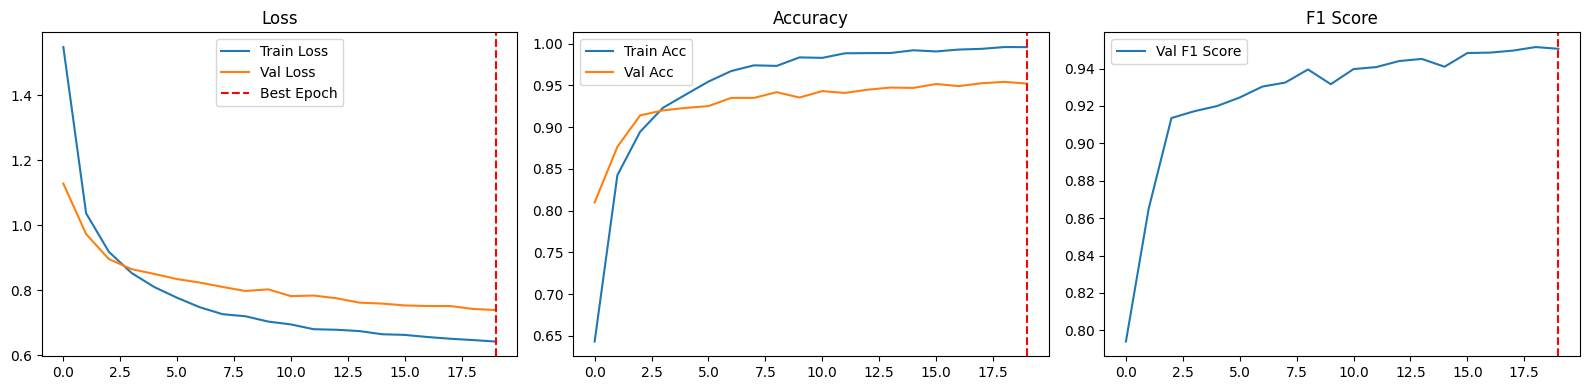


=== Fold 2 Training ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


📦 Training Fold...
✅ Fold Summary → Train Acc: 0.9969 | Val Acc: 0.9560 | Train Loss: 0.6386 | Val Loss: 0.7449


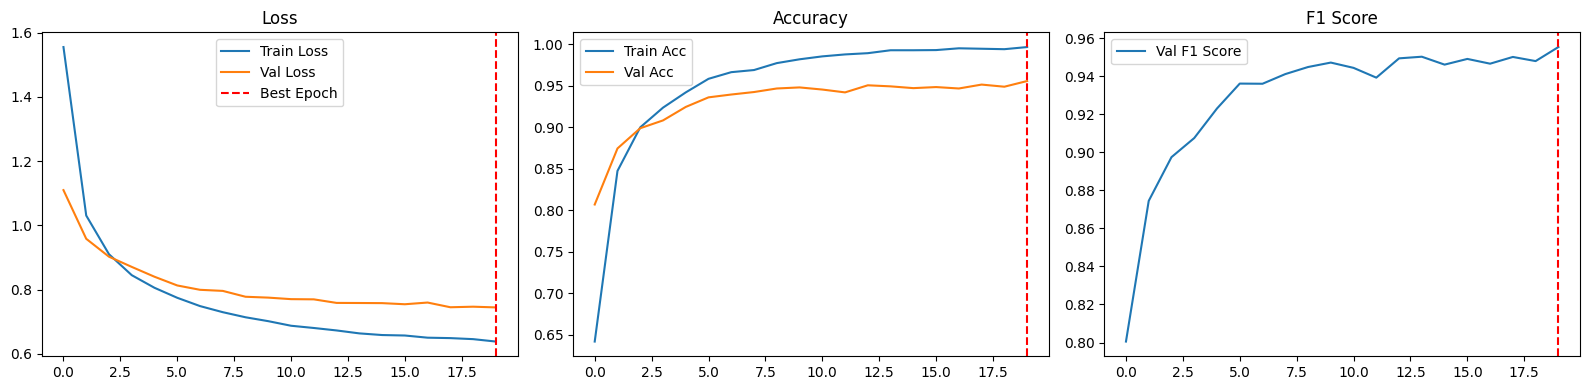


=== Fold 3 Training ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


📦 Training Fold...
✅ Fold Summary → Train Acc: 0.9944 | Val Acc: 0.9461 | Train Loss: 0.6424 | Val Loss: 0.7658


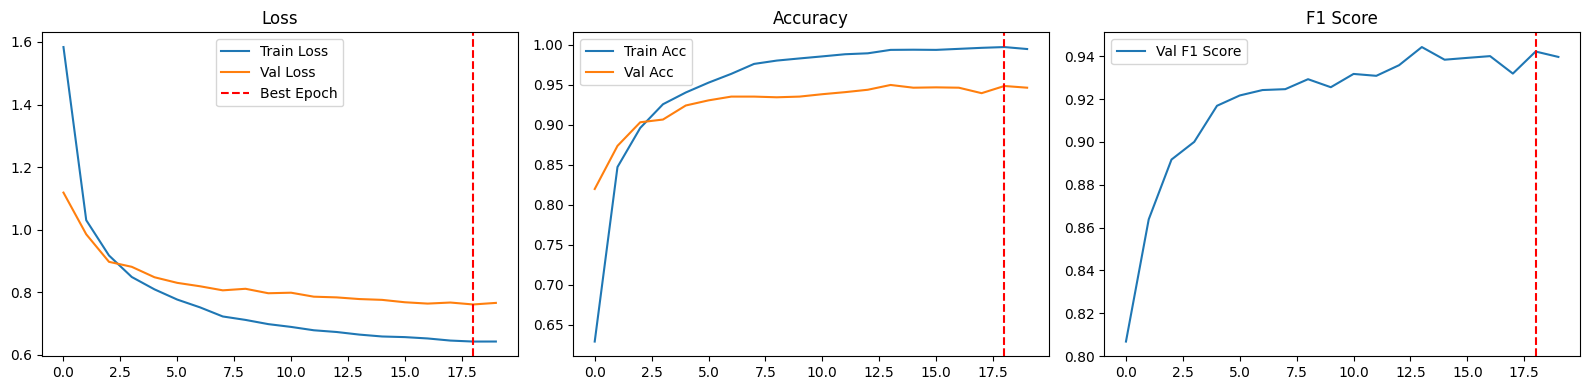


=== Fold 4 Training ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


📦 Training Fold...
✅ Fold Summary → Train Acc: 0.9959 | Val Acc: 0.9423 | Train Loss: 0.6416 | Val Loss: 0.7643


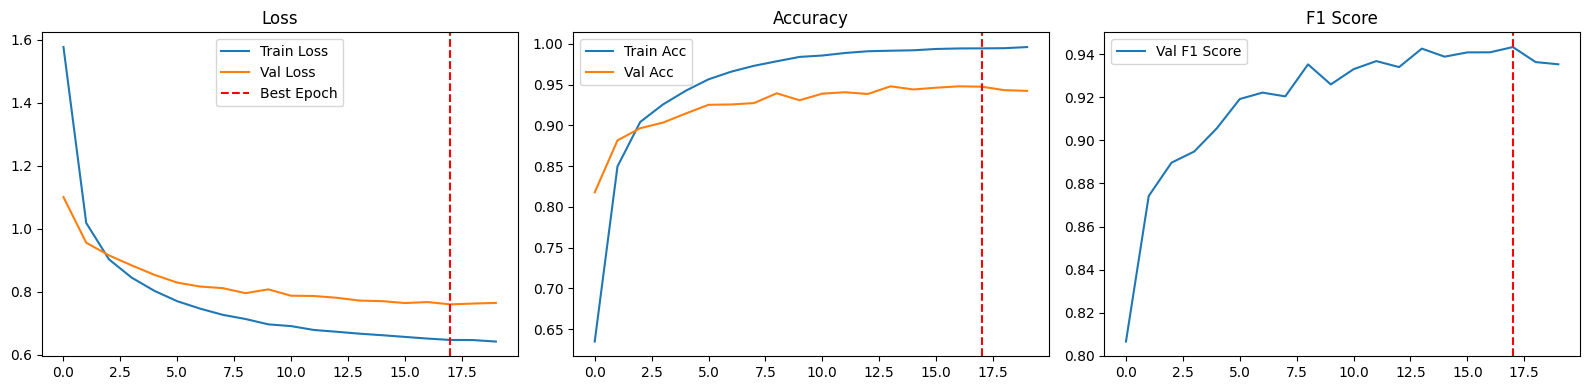


=== Fold 5 Training ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


📦 Training Fold...
✅ Fold Summary → Train Acc: 0.9951 | Val Acc: 0.9444 | Train Loss: 0.6440 | Val Loss: 0.7649


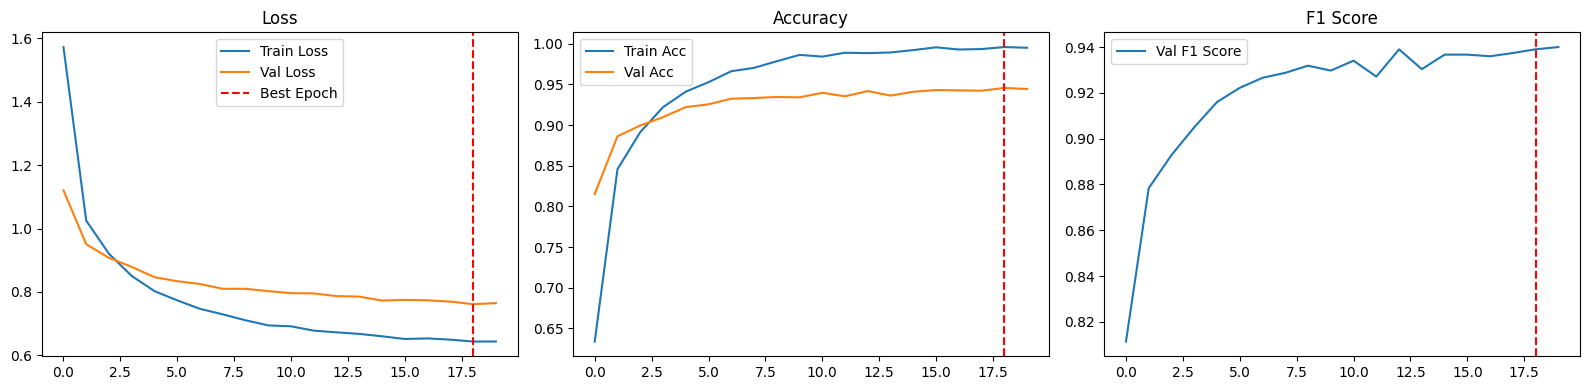


✅ 평균 Val Acc: 0.9499
✅ 평균 Val F1:  0.9461


In [14]:
# ✅ 6. Train / Val K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n=== Fold {fold+1} Training ===")

    X_train = [X_trainval[i] for i in train_idx]
    X_val   = [X_trainval[i] for i in val_idx]

    train_indices = [i for i, (path, _) in enumerate(folder_ds.samples) if path in X_train]
    val_indices   = [i for i, (path, _) in enumerate(folder_ds.samples) if path in X_val]

    train_dataset = TransformDataset(folder_ds, train_indices, transform=train_transform)
    val_dataset   = TransformDataset(folder_ds, val_indices, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = InferenceModel("efficientnet_b0", num_classes=len(folder_classes))
    trained_model, history = train_fold(model, train_loader, val_loader, folder_classes)

    best_epoch = np.argmin(history['val_loss']) + 1 
    model_path = f"/kaggle/working/effb0_fold{fold+1}.pth"
    torch.save(trained_model.state_dict(), model_path)

     # 💾 Fold별 성능 저장
    fold_metrics.append({
        'fold': fold + 1,
        'best_epoch': best_epoch,
        'val_acc': history['val_acc'][best_epoch - 1],
        'val_f1': history['f1'][best_epoch - 1],
        'model_path': model_path
    })
    
# 📊 Fold 평균 출력
val_accs = [m['val_acc'] for m in fold_metrics]
val_f1s  = [m['val_f1'] for m in fold_metrics]

print(f"\n✅ 평균 Val Acc: {np.mean(val_accs):.4f}")
print(f"✅ 평균 Val F1:  {np.mean(val_f1s):.4f}")


🏆 Best Fold: 2 (F1: 0.9552)
📂 Loading best model from: /kaggle/working/effb0_fold2.pth
🧪 최종 Test Set 결과:
              precision    recall  f1-score   support

          고철       0.98      0.77      0.86       125
          비닐       0.86      0.73      0.79       123
          상자       0.77      0.91      0.83       127
       소형폐가전       0.76      0.94      0.84       528
        스티로폼       0.96      0.99      0.97       200
         신문지       1.00      0.76      0.86        70
          유리       0.85      0.93      0.89       406
     음식물 쓰레기       0.96      0.73      0.83        88
          의류       0.89      0.83      0.86       159
        전자제품       0.91      0.83      0.87       143
         전지류       0.87      0.74      0.80       215
          책자       0.75      0.72      0.74        54
          캔류       0.96      0.56      0.71       175
        플라스틱       0.76      0.83      0.80       262
         형광등       0.93      0.94      0.94       249

    accuracy                

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 52384 (\N{HANGUL SYLLABLE CEOL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 45776 (\N{HANGUL SYLLABLE NIL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn

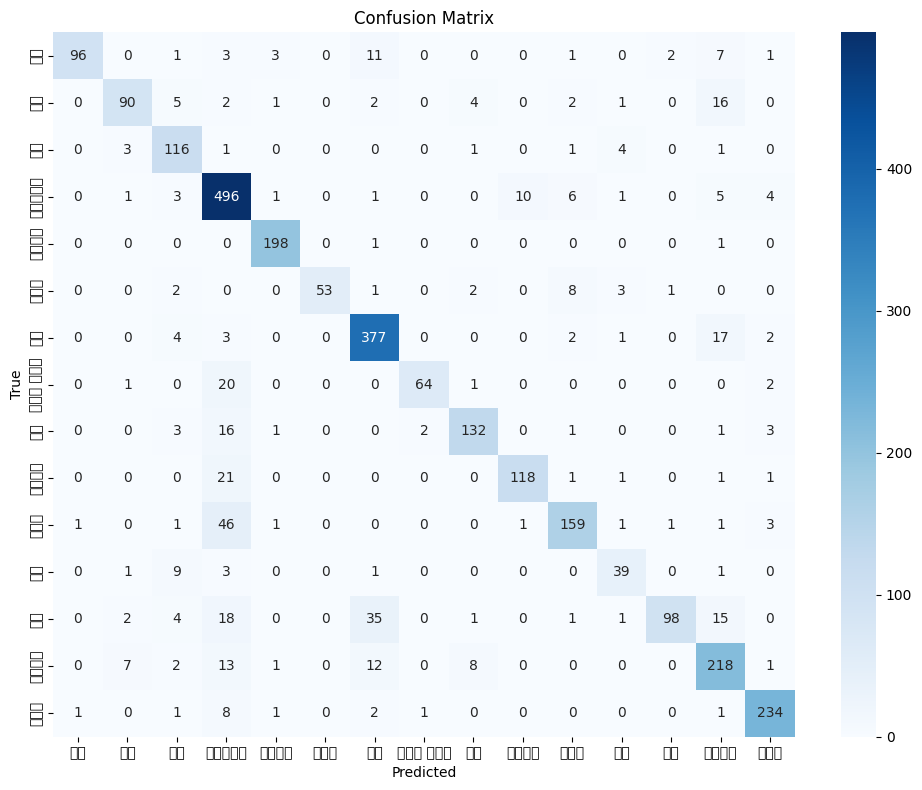

NameError: name 'print_classwise_report' is not defined

In [15]:
# 🔽 모든 Fold 끝나고 나서
best_fold = max(fold_metrics, key=lambda x: x['val_f1'])  # 또는 x['val_acc']
best_model_path = best_fold['model_path']

print(f"\n🏆 Best Fold: {best_fold['fold']} (F1: {best_fold['val_f1']:.4f})")
print(f"📂 Loading best model from: {best_model_path}")

best_model = InferenceModel("efficientnet_b0", num_classes=len(folder_classes))
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)
best_model.eval()

# 🔽 이후 test set 평가
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits, _ = best_model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# 결과 출력
used_class_indices = sorted(set(all_labels + all_preds))
used_class_names = [folder_classes[i] for i in used_class_indices]
print("🧪 최종 Test Set 결과:")
print(classification_report(all_labels, all_preds, labels=used_class_indices, target_names=used_class_names))
plot_confusion_matrix(all_labels, all_preds, used_class_names)
print_classwise_report(all_labels, all_preds, folder_classes)


In [ ]:
from collections import Counter
print(Counter(y_trainval))  # 클래스별 샘플 수 확인
from collections import Counter
labels = [label for _, label in folder_ds.samples]
Counter(labels)

In [15]:
labels = sorted(list(set(all_labels + all_preds)))  # 실제 예측에 등장한 클래스만 추림
print(classification_report(all_labels, all_preds, labels=labels, target_names=[folder_classes[i] for i in labels]))


NameError: name 'all_preds' is not defined